<a href="https://colab.research.google.com/github/Uswatyusuff/Project2_C24/blob/model-deployment/CSRNET_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/CSRNET_Project_Folder

/content/gdrive/.shortcut-targets-by-id/1jlVA7DMM4pn_TrGZ9fwozcUd-GblJwYO/CSRNET_Project_Folder


In [ ]:
! git clone https://github.com/leeyeehoo/CSRNet-pytorch.git

fatal: destination path 'CSRNet-pytorch' already exists and is not an empty directory.


In [3]:
%cd /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch


/content/gdrive/.shortcut-targets-by-id/1jlVA7DMM4pn_TrGZ9fwozcUd-GblJwYO/CSRNET_Project_Folder/CSRNet-pytorch


In [4]:
!pip install opencv-python
!pip install image
!pip install torch torchvision


# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
import torch
from tqdm import tqdm
%matplotlib inline


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 86.4 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=05e632a70e545ad404a138e96aa29514c7e65a8ef28fa80086f84407e2e85e62
  Stored in directory: /root/.cache/pip/wheels/62/40/4f/3c9a8d0f22a1a6f966975a460e5cb509a1e7dc42e2ce5d9a6d
Successfully built image
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<ipython-input-4-07ad3999b73d>:14: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [5]:
from model import CSRNet

In [6]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [7]:
root = "/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch"
part_A_train = os.path.join(root,'part_B/train_data','images')
part_A_test = os.path.join(root,'part_B/test_data','images')
path_sets = [part_A_train,part_A_test]

In [ ]:
#setting image locations
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
#creating density map for each image
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images/IMG_120.jpg
(768, 1024)
generate density...


<ipython-input-6-5249dfb3137a>:24: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images/IMG_108.jpg
(768, 1024)
generate density...
done.
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images/IMG_111.jpg
(768, 1024)
generate density...
done.
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images/IMG_10.jpg
(768, 1024)
generate density...
done.
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images/IMG_12.jpg
(768, 1024)
generate density...
done.
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images/IMG_118.jpg
(768, 1024)
generate density...
done.
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images/IMG_119.jpg
(768, 1024)
generate density...
done.
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images/IMG_101.jpg
(768, 1024)
generate density...
done.
/content/gdrive/MyDrive/CSRNET_Project_Folde

KeyboardInterrupt: 

In [ ]:
plt.imshow(Image.open(img_paths[0]))

NameError: name 'img_paths' is not defined

In [ ]:
#obtain density heat map of sample image
gt_file=h5py.File(img_paths[0].replace('.jpg','.h5').replace('image','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)


NameError: name 'img_paths' is not defined

In [ ]:
# to obtain the number of peoplein the image
np.sum(groundtruth)

463.5296

In [ ]:
import os
import json

def create_image_list_json(directory, output_json="image_paths.json"):
    # Supported image formats
    valid_extensions = (".jpg", ".jpeg", ".png")

    # Get absolute paths of all image files in the directory
    image_paths = [os.path.abspath(os.path.join(directory, f))
                   for f in os.listdir(directory)
                   if f.lower().endswith(valid_extensions)]

    # Save the list as a JSON file
    with open(output_json, "w") as json_file:
        json.dump(image_paths, json_file, indent=4)

    print(f"JSON file saved: {output_json}")

# Example usage
image_directory = "/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/part_B/train_data/images"
output_file = "/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad_train.json"

create_image_list_json(image_directory, output_file)


JSON file saved: /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/trainB.json


In [ ]:
%cd /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch

!python train.py train.json test.json --gpu 0 --task 0


Streaming output truncated to the last 5000 lines.
Epoch [83], Step [990/2744], Loss: 25.1343
Epoch [83], Step [1000/2744], Loss: 37.2714
Epoch [83], Step [1010/2744], Loss: 7.1591
Epoch [83], Step [1020/2744], Loss: 15.7131
Epoch [83], Step [1030/2744], Loss: 90.2635
Epoch [83], Step [1040/2744], Loss: 30.7403
Epoch [83], Step [1050/2744], Loss: 0.5803
Epoch [83], Step [1060/2744], Loss: 8.4107
Epoch [83], Step [1070/2744], Loss: 0.2972
Epoch [83], Step [1080/2744], Loss: 77.8156
Epoch [83], Step [1090/2744], Loss: 43.0659
Epoch [83], Step [1100/2744], Loss: 43.6168
Epoch [83], Step [1110/2744], Loss: 10.5069
Epoch [83], Step [1120/2744], Loss: 0.6382
Epoch [83], Step [1130/2744], Loss: 2.7834
Epoch [83], Step [1140/2744], Loss: 40.1059
Epoch [83], Step [1150/2744], Loss: 74.2991
Epoch [83], Step [1160/2744], Loss: 22.5385
Epoch [83], Step [1170/2744], Loss: 1.3294
Epoch [83], Step [1180/2744], Loss: 6.2548
Epoch [83], Step [1190/2744], Loss: 17.1080
Epoch [83], Step [1200/2744], Loss

In [ ]:

from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])
model = CSRNet()
#defining the model
model = model.cuda()
#loading the trained weights
checkpoint = torch.load('/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/0model_best_early_stopping_10.pth', weights_only=True)

# Load state dict with strict=False
model.load_state_dict(checkpoint['state_dict'], strict=False)


<All keys matched successfully>

In [ ]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

NameError: name 'img_paths' is not defined

Predicted Count :  433


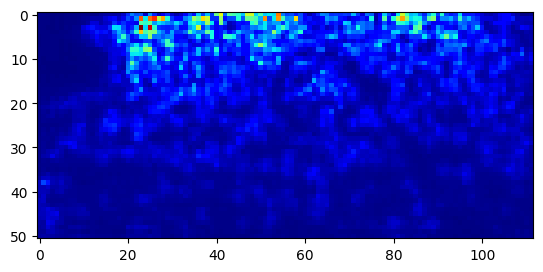

Original Count :  382


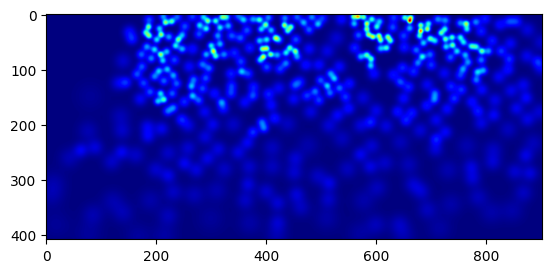

Original Image


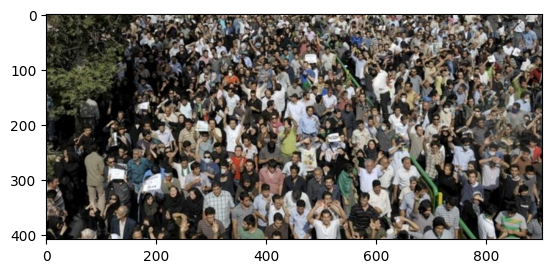

In [ ]:
from matplotlib import cm as c
img = transform(Image.open('/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/Shangai_Tech/test_data/images/IMG_100.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('part_A/test_data/ground_truth/IMG_100.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/Shangai_Tech/test_data/images/IMG_100.jpg'))
plt.show()

Predicted Count :  1070


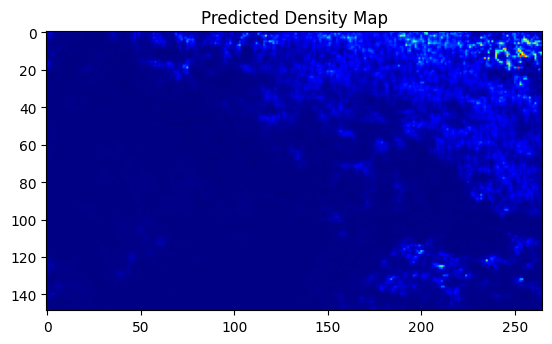

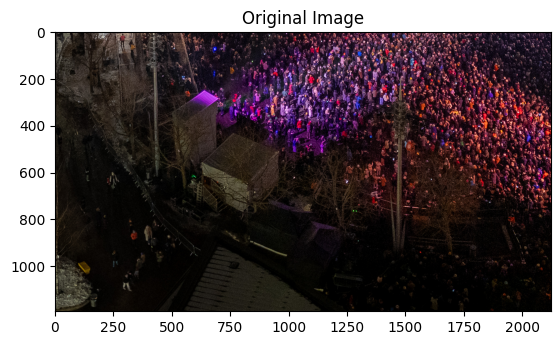

In [ ]:
# Load and preprocess the image
img = transform(Image.open('/content/patch_2_1.png').convert('RGB')).cuda()

# Run the model to get predictions without computing gradients
with torch.no_grad():
    output = model(img.unsqueeze(0))

predicted_count = int(output.detach().cpu().sum().numpy())
print("Predicted Count : ", predicted_count)

# Display the predicted density map
density_map = np.asarray(output.detach().cpu().reshape(
    output.detach().cpu().shape[2],
    output.detach().cpu().shape[3]
))
plt.imshow(density_map, cmap=plt.cm.jet)
plt.title("Predicted Density Map")
plt.show()

# Optionally, display the original image
original_img = plt.imread('/content/patch_2_1.png')
plt.imshow(original_img)
plt.title("Original Image")
plt.show()
